## John Klincks's Review of Paper 2

He asked:

*"What is the effect of vertical mixing on the distribution and concentration of the tracers? How large is the diffusive flux at the top of the pool? In particular, the initial concentration of a tracer at the shelf break is used to define the pool of upwelled water onto the shelf. I suspect that vertical diffusion does not play a major role, but it would be nice to have some idea that its effect on the size of the pool was considered. (section 2.4, L432ff)"*

We once exstimated what would be the diffusive flux of tracer at the top of the pool and found that it was much smaller than the advective flux we said is feeding the pool. That is why we ignored it from the scaling. However, in previous runs (paper 1) we found that the pool's boundary is higher and the area is smaller when there is enhanced diffusivity on th shelf (E.g. with $K_v=10^{-3}$ m$^{2}$s$^{-1}$)

Here we show broad estimates of what the diffusive flux is at the top of the pool and at shelf break for every tracer.


In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [44]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    RC = nbl.variables['Z'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','DS 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,\
    sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                            [sb_conc_A, sb_conc_B],
                            [sb_Ast, sb_Bar],
                            [drC_A, drC_B],
                            [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*profile.data/1000)/1E-3 # mumol/kg mu mol/m^3
                
            else:
                tr_profile = (nbl.variables[trac][0,:,10,180])/1E-3 # muM to mu mol/m^1
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            sb_array[ii] = tr_profile[sb_ind]

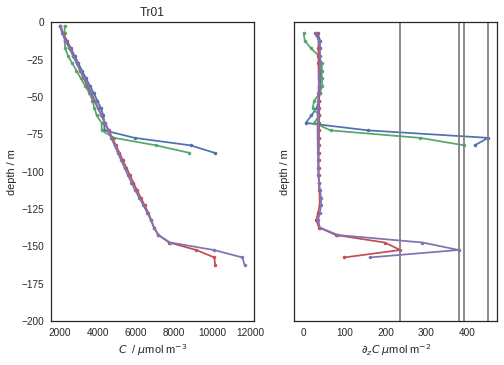

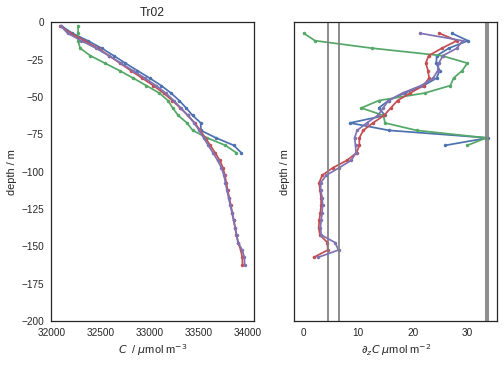

[ -559.50951737 -2121.01373625 -5123.36456738 -4374.4647955
 -9653.33338359 -8282.03091113]
[ -1039.00326693  -1826.8184746   -4192.47915251  -4532.96032914
 -11315.79181429  -9421.88012947]
[ -718.11888939 -1644.7696041  -1938.2765883   -869.70137789
 -8253.79273706 -8166.05178868]
[ -754.88791631 -2262.278585   -2857.16510563 -1237.34842863
 -7330.69169153 -7212.71894857]


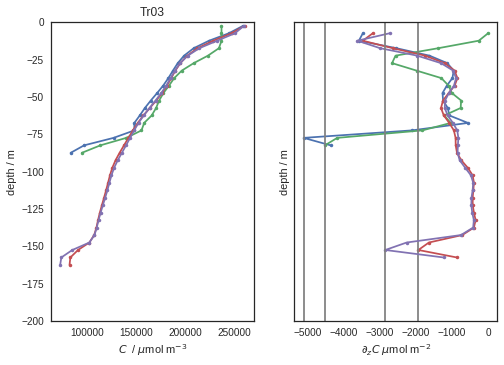

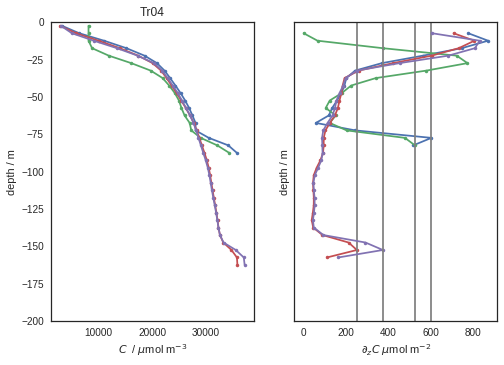

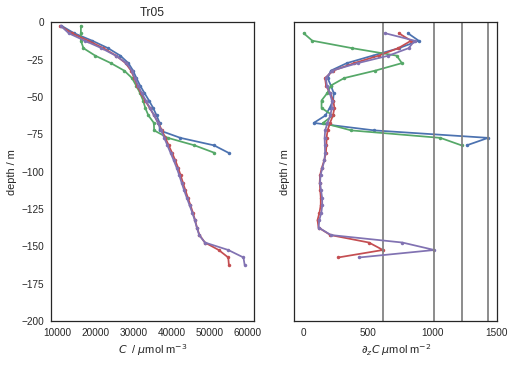

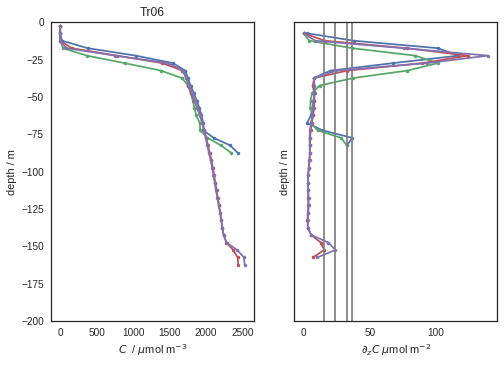

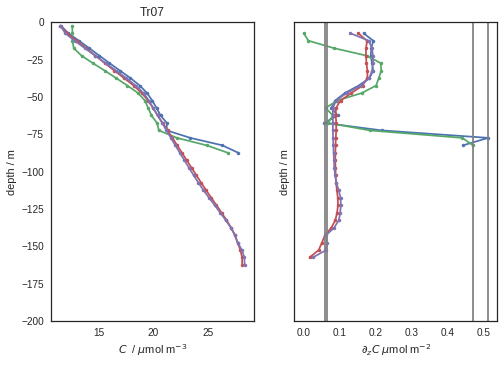

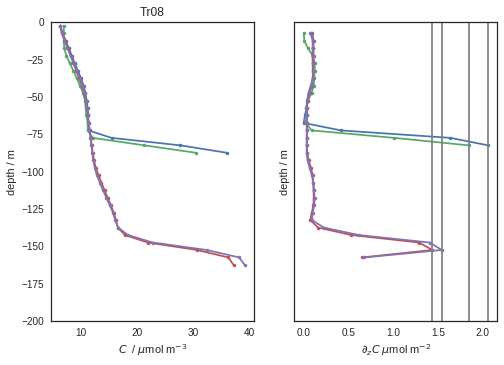

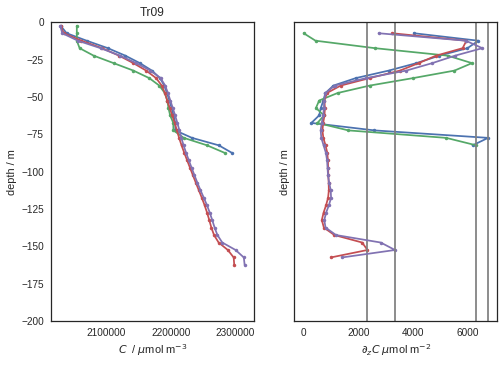

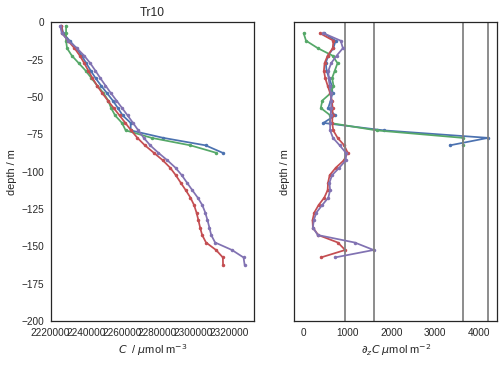

In [84]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
Z_zind = [30,20,14,21]
g = 9.81
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBar = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileAst = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
ptr_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/ptracersGlob.nc'
ptr_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc'

state_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc'
stateArgo = xr.open_dataset(state_fileArgo)
state_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc'
statePath = xr.open_dataset(state_filePath)
        
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','DS 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_gradZ_Ast = np.empty(len(labels))
sb_gradZ_Argo = np.empty(len(labels))
sb_gradZ_Bar = np.empty(len(labels))
sb_gradZ_Path = np.empty(len(labels))
sb_gradtop_Ast = np.empty(len(labels))
sb_gradtop_Argo = np.empty(len(labels))
sb_gradtop_Bar = np.empty(len(labels))
sb_gradtop_Path = np.empty(len(labels))
sb_gradS2_Ast = np.empty(len(labels))
sb_gradS2_Argo = np.empty(len(labels))
sb_gradS2_Bar = np.empty(len(labels))
sb_gradS2_Path = np.empty(len(labels))
N_top_Ast = np.empty(len(labels))
N_top_Argo = np.empty(len(labels))
N_top_Bar = np.empty(len(labels))
N_top_Path = np.empty(len(labels))
S2_xind = [300,300,250,250]
S2_yind = [255,255,170,170]
S2_zind = [17,17,32,32]

for ii, trac in zip(range(len(tracers)),tracers):
    fig,(ax,ax1) = plt.subplots(1,2, sharey=True)
    
    for pfile,sb_ind,head_ind,Z_ind,grad_array,gradtop_array,gradS2_array,drc,state,Ntop,S2_x,S2_y,S2_z \
    in zip([ptr_fileAst,ptr_fileArgo,ptr_fileBar,ptr_filePath],
            [sb_Ast,sb_Ast,sb_Bar, sb_Bar],
            head_zind,
            Z_zind,
            [sb_gradZ_Ast,sb_gradZ_Argo,sb_gradZ_Bar,sb_gradZ_Path],
            [sb_gradtop_Ast,sb_gradtop_Argo,sb_gradtop_Bar,sb_gradtop_Path],
            [sb_gradS2_Ast,sb_gradS2_Argo,sb_gradS2_Bar,sb_gradS2_Path],
            [drC_A, drC_A, drC_B, drC_B],
            [stateA,stateArgo,stateB,statePath],
            [N_top_Ast,N_top_Argo,N_top_Bar,N_top_Path],S2_xind,S2_yind, S2_zind):
        
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profileS2 = (1E-3*nbl.variables[trac][8,:,S2_y,S2_x])/1E-3 # nM to mu mol/m^3
                
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*profile.data/1000)/1E-3 # muM to mu mol/m^3 
                
                profileS2 = nbl.variables[trac][8,:,S2_y,S2_x]
                densityS2 = call_rho(8,state,slice(0,104),S2_x,S2_y)
                tr_profileS2 = (densityS2.data*profileS2.data/1000)/1E-3 # muM to mu mol/m^3 
                
               
            else:
                tr_profile = nbl.variables[trac][0,:,10,180]/1E-3 # muM to mu mol/m^3
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profileS2 = nbl.variables[trac][8,:,S2_y,S2_x]/1E-3 # muM to mu mol/m^3
                
                
            Ntop[ii] = np.nanmean((-(g/RhoRef)* \
                                ((density.data[head_ind-2:sb_ind-2]-
                                  density.data[head_ind:sb_ind])/ \
                                 (drc[head_ind-2:sb_ind-2] + 
                                  drc[head_ind:sb_ind])))**0.5)
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            tr_gradS2 = (tr_profileS2[2:]-tr_profileS2[:-2])/(drc[3:]+drc[1:-2])
            grad_array[ii] = np.nanmean(tr_grad[head_ind:head_ind+Z_ind]) 
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-10:sb_ind])
            if trac == 'Tr03':
                gradS2_array[ii] = np.nanmin((tr_gradS2[S2_z-5:S2_z-1]))
                print(tr_gradS2[S2_z-5:S2_z+1])
            else:
                gradS2_array[ii] = np.nanmax(tr_gradS2[S2_z-5:S2_z+1])
                
        ax.plot(tr_profileS2[:S2_z+1],RC[:S2_z+1],'.-')
        ax.set_title(trac)
        ax.set_ylabel('depth / m')
        ax.set_xlabel('$C$  / $\mu$mol m$^{-3}$' )
        ax.set_ylim(-200,0)
        ax1.plot(tr_gradS2[:S2_z-1],RC[1:S2_z],'.-')
        ax1.axvline(gradS2_array[ii], color='0.5')
        ax1.set_ylabel('depth / m')
        ax1.set_xlabel('$\partial_z C$ $\mu$mol m$^{-2}$' )
        ax1.set_ylim(-200,0)
    plt.show()

### Scaling pool and $\Phi_{Tr}$

In [85]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)

g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
Wsbs = np.array([15700,15700,13000,13000])
R = np.array([4500,4500,5000,5000])
L = np.array([21800,21800,6400,6400])
Hhs = [97.5,97.5,172.5,172.5]
Hss = [150,150,200,200]
Kv = 1E-5

Plotting $K_v\partial_zC_{top}A_{pool}$/$\Phi_{Tr}$, using gradient above shelf break in diff flux calculation


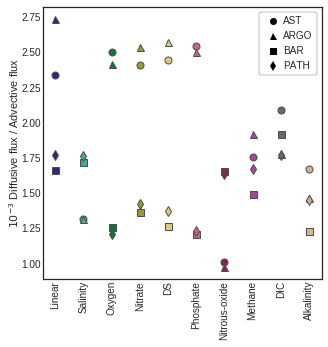

In [86]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax0=plt.subplots(1,1,figsize=(5,5))

labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS',
              'Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677',
           '#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01',
        'UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
N_top = [N_top_Ast, N_top_Argo, N_top_Bar, N_top_Path]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad,gradtop,Ntop,conc,Hh,Hs,ff,nn,uu,ll,ww,wsb,ss, rr, mark in zip(exp_files, 
                                                                        runs,runs_phi,
                                                                        labels_exp,
                                                                        can_Area,exps,
                                                                        sb_grad,
                                                                        sb_gradtop,
                                                                        N_top,
                                                                        sb_conc,Hhs,Hss,
                                                                        f,N,U,L,Wiso,
                                                                        Wsbs,s,R,
                                                                        markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii] # advective transport [C]m^3/s
        diff_flux = Kv*gradtop[ii] # diffusive flux in [C]m/s
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             'o', mfc = col, mec='0.3',mew=1, 
                             label = tr_lab)
                else:
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                              '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             's', mfc = col, mec='0.3',mew=1)
                else:
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                            'd', mfc = col, mec='0.3',mew=1)        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(1,1.0), handletextpad=0, frameon=True, edgecolor='k' )

ax0.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax0.set_xticklabels(['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate',
                     'Nitrous-oxide','Methane','DIC','Alkalinity'], rotation=90)
ax0.set_ylabel(r'$10^{-3}$ Diffusive flux / Advective flux', labelpad=0)

print(r'Plotting $K_v\partial_zC_{top}A_{pool}$/$\Phi_{Tr}$, using gradient above shelf break in diff flux calculation')

Using gradient at shelf break in diffusive flux calculation


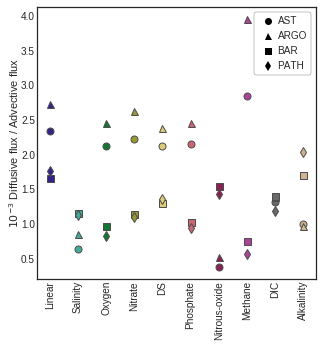

In [87]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax0=plt.subplots(1,1,figsize=(5,5))

labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS',
              'Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677',
           '#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01',
        'UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
N_top = [N_top_Ast, N_top_Argo, N_top_Bar, N_top_Path]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad,gradtop,Ntop,conc,Hh,Hs,ff,nn,uu,ll,ww,wsb,ss, rr, mark in zip(exp_files, 
                                                                        runs,runs_phi,
                                                                        labels_exp,
                                                                        can_Area,exps,
                                                                        sb_grad,
                                                                        sb_gradtop,
                                                                        N_top,
                                                                        sb_conc,Hhs,Hss,
                                                                        f,N,U,L,Wiso,
                                                                        Wsbs,s,R,
                                                                        markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii] # advective transport [C]m^3/s
        diff_flux = Kv*grad[ii] # diffusive flux in [C]m/s
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             'o', mfc = col, mec='0.3',mew=1, 
                             label = tr_lab)
                else:
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                              '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             's', mfc = col, mec='0.3',mew=1)
                else:
                    ax0.plot(ii,1000*np.nanmax(area[ii,:])*diff_flux/PhidC,
                            'd', mfc = col, mec='0.3',mew=1)        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(1,1.0), handletextpad=0, frameon=True, edgecolor='k' )

ax0.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax0.set_xticklabels(['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate',
                     'Nitrous-oxide','Methane','DIC','Alkalinity'], rotation=90)
ax0.set_ylabel(r'$10^{-3}$ Diffusive flux / Advective flux', labelpad=0)

print('Using gradient at shelf break in diffusive flux calculation')

Using max gradient at S2 diffusive flux calculation


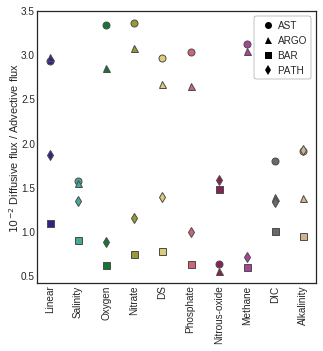

In [90]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax0=plt.subplots(1,1,figsize=(5,5))

labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS',
              'Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677',
           '#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01',
        'UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradS2 = [sb_gradS2_Ast,sb_gradS2_Argo, sb_gradS2_Bar,sb_gradS2_Path]
N_top = [N_top_Ast, N_top_Argo, N_top_Bar, N_top_Path]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad,gradS2,Ntop,conc,Hh,Hs,ff,nn,uu,ll,ww,wsb,ss, rr, mark in zip(exp_files, 
                                                                        runs,runs_phi,
                                                                        labels_exp,
                                                                        can_Area,exps,
                                                                        sb_grad,
                                                                        sb_gradS2,
                                                                        N_top,
                                                                        sb_conc,Hhs,Hss,
                                                                        f,N,U,L,Wiso,
                                                                        Wsbs,s,R,
                                                                        markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Wsb = wsb
        calF = F(Ro(uu,ff,ww))
        PhidC = uu*(ZZ**2)*calF*Wsb*grad[ii] # advective transport [C]m^3/s
        diff_flux = Kv*gradS2[ii] # diffusive flux in [C]m/s
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(ii,100*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             'o', mfc = col, mec='0.3',mew=1, 
                             label = tr_lab)
                else:
                    ax0.plot(ii,100*np.nanmax(area[ii,:])*diff_flux/PhidC,
                              '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(ii,100*np.nanmax(area[ii,:])*diff_flux/PhidC,
                             's', mfc = col, mec='0.3',mew=1)
                else:
                    ax0.plot(ii,100*np.nanmax(area[ii,:])*diff_flux/PhidC,
                            'd', mfc = col, mec='0.3',mew=1)        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(1.0,1.0), handletextpad=0, frameon=True, edgecolor='k' )

ax0.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax0.set_xticklabels(['Linear','Salinity','Oxygen','Nitrate','DS','Phosphate',
                     'Nitrous-oxide','Methane','DIC','Alkalinity'], rotation=90)
ax0.set_ylabel(r'$10^{-2}$ Diffusive flux / Advective flux', labelpad=0)

print('Using max gradient at S2 diffusive flux calculation')

Using the maximum tracer gradient at virtual station S2 and an ambient vertical diffusivity $K_v=10^{-5}$ m$^2$s$^{-1}$ (like we used in the simulations) at day 4 (when the pool is recently formed), the diffusive flux at the top of the pool is 100 times smaller than the advective flux and that is why we ignored it in the scaling. If we consider the initial tracer gradient at shelf break or on the shelf then the diffusive flux is even smaller, 1000 times smaller than the advective flux. 

However, if there is enhanced vertical diffusivity on the shelf by 100 times, so that $K_v=10^{-3}$ m$^2$s$^{-1}$ on the shelf (which is a bit steep for that environment), then the pool's area and concentration would be impacted by the enhanced diffusivity on the shelf. That is what we saw in previous runs (from paper 1).


We have added this considerations to the discussion section (or to the scaling section?)